In [1]:
# needed libraries
from numpy.core.fromnumeric import mean
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D, Conv1D, LSTM, GRU, Bidirectional, SpatialDropout1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint

In [2]:
# Constants
TAG_RE = re.compile(r'<[^>]+>')
DATA_PATH = "IMDB Dataset.csv"
MAX_LEN = 100
checkpoint_filepath_lstm = 'checkpoint/weights_lstm'
checkpoint_filepath_cnn = 'checkpoint/weights_cnn'
checkpoint_filepath_bi_lstm = 'checkpoint/weights_bi_lstm'
checkpoint_filepath_gru = 'checkpoint/weights_gru'
checkpoint_filepath_best_lstm = 'checkpoint/weights_best_lstm'

def create_checkpoint(path):
    model_checkpoint = ModelCheckpoint(
        filepath = path,
        save_weights_only = True,
        monitor = 'val_acc',
        mode = 'max',
        save_best_only = True
    )
    
    return model_checkpoint

In [3]:
def read_data(path):
    # Kaggle dataset of 50K Moview Reviews
    movie_reviews = pd.read_csv(path)
    movie_reviews.isnull().values.any()
    
    return movie_reviews

In [4]:
def remove_tags(text):

    return TAG_RE.sub('', text)

In [5]:
def preprocess_text(review):
    review = remove_tags(review)
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = re.sub(r"\s+[a-zA-Z]\s+", ' ', review)
    review = re.sub(r'\s+', ' ', review)

    return review

In [6]:
def create_train_test(movie_reviews):
    X = []
    reviews = list(movie_reviews['review'])
    for review in reviews:
        X.append(preprocess_text(review))
    y = movie_reviews['sentiment']
    y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    return X_train, X_test, y_train, y_test

In [23]:
def prepare_embedding_layer(X_train, X_test):
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    vocab_size = len(tokenizer.word_index) + 1 # unique words of the corpus
    X_train = pad_sequences(X_train, padding='post', maxlen=MAX_LEN)
    X_test = pad_sequences(X_test, padding='post', maxlen=MAX_LEN)

    embeddings_dictionary = dict()
    glove_file = open('glove.6B.100d.txt', encoding="utf8")

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
    glove_file.close()

    embedding_matrix = np.zeros((vocab_size, 100))
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

    return X_train, X_test, embedding_matrix, vocab_size, tokenizer

In [12]:
def print_graphs(out_values):
    plt.plot(out_values.history['acc'])
    plt.plot(out_values.history['val_acc'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.show()

    plt.plot(out_values.history['loss'])
    plt.plot(out_values.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.show()

In [13]:
def create_model_cnn(vocab_size, embedding_matrix):
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=MAX_LEN , trainable=False)
    model.add(embedding_layer)
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    # print(model.summary())

    return model

In [14]:
def train_cnn(X_train, y_train, X_test, y_test, model):
    model_checkpoint_callback_cnn = create_checkpoint(checkpoint_filepath_cnn)
    # In each epoch the actual hyperparameters will be tested with the validation set
    out_values = model.fit(X_train, y_train, batch_size=128, epochs=6,
                           callbacks=[model_checkpoint_callback_cnn],
                           verbose=1,
                           validation_split=0.2)
    score_test = model.evaluate(X_test, y_test, verbose=1)
    print("Test Score for the Convolutional Neural Network:", score_test[0])
    print("Test Accuracy for the Convolutional Neural Network:", score_test[1])
    print_graphs(out_values)

    return model

In [15]:
def create_model_lstm(vocab_size, embedding_matrix):
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=MAX_LEN , trainable=False)
    model.add(embedding_layer)
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    return model

In [16]:
def train_lstm(X_train, y_train, X_test, y_test, model):
    model_checkpoint_callback_lstm = create_checkpoint(checkpoint_filepath_lstm)
    out_values = model.fit(X_train, y_train, batch_size=128, epochs=6,
                           callbacks=[model_checkpoint_callback_lstm],
                           verbose=1, validation_split=0.2)

    score_test = model.evaluate(X_test, y_test, verbose=1)
    print("Test Score in the Recurrent Neural Network:", score_test[0])
    print("Test Accuracy in the Recurrent Neural Network:", score_test[1])
    print_graphs(out_values)

    return model

In [17]:
# Improved lstm model: We are going to try Bidirectional LSTM and 
def create_bilateral_lstm(vocab_size, embedding_matrix):
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=MAX_LEN , trainable=False)
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(units = 64,                             
              return_sequences=True),
              input_shape=(X_train.shape[0], X_train.shape[1])))
    model.add(Bidirectional(LSTM(64)))
    model.add((Dense(1)))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    return model

def create_gru(vocab_size, embedding_matrix):
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=MAX_LEN , trainable=False)
    model.add(embedding_layer)
    model.add(GRU (units = 64, return_sequences = True,
                input_shape = [X_train.shape[0], X_train.shape[0]]))
    model.add(Dropout(0.2))
    model.add(GRU (units = 64))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [18]:
def train_bilateral_lstm(X_train, y_train, X_test, y_test, model):
    model_checkpoint_callback_bilstm = create_checkpoint(checkpoint_filepath_bi_lstm)
    out_values = model.fit(X_train, y_train, batch_size=128, epochs=6,
                           callbacks=[model_checkpoint_callback_bilstm],
                           verbose=1, validation_split=0.2)

    score_test = model.evaluate(X_test, y_test, verbose=1)
    print("Test Score for the Bilateral LSTM model:", score_test[0])
    print("Test Accuracy for the Bilateral LSTM model:", score_test[1])
    print_graphs(out_values)
    
    return model

def train_gru(X_train, y_train, X_test, y_test, model):
    model_checkpoint_callback_gru = create_checkpoint(checkpoint_filepath_gru)
    out_values = model.fit(X_train, y_train, batch_size=128, epochs=6,
                           callbacks=[model_checkpoint_callback_gru],
                           verbose=1, validation_split=0.2)

    score_test = model.evaluate(X_test, y_test, verbose=1)
    print("Test Score for the GRU model:", score_test[0])
    print("Test Accuracy for the GRU model:", score_test[1])
    print_graphs(out_values)
    
    return model

In [19]:
# We are going to try to improve the LSTM model by adding a SpatialDropout1D layer and other Dropout and Dense layers
def create_impr_lstm(vocab_size, embedding_matrix):
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=MAX_LEN , trainable=False)
    model.add(embedding_layer)
    model.add(SpatialDropout1D(0.25))
    model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [20]:
def train_impr_lstm(X_train, y_train, X_test, y_test, model):
    model_checkpoint_callback_best_lstm = create_checkpoint(checkpoint_filepath_best_lstm)
    out_values = model.fit(X_train, y_train, batch_size=128, epochs=6,
                           callbacks=[model_checkpoint_callback_best_lstm],
                           verbose=1, validation_split=0.2)

    score_test = model.evaluate(X_test, y_test, verbose=1)
    print("Test Score for the best LSTM model:", score_test[0])
    print("Test Accuracy for the best LSTM model:", score_test[1])
    print_graphs(out_values)
    
    return model

In [21]:
def make_prediction(model, path, rvw):
    model.load_weights(path)
    rvw = tokenizer.texts_to_sequences(rvw)
    #padding the review to have exactly the same shape as `embedding_2` input
    rvw = pad_sequences(rvw, maxlen=MAX_LEN, dtype='int32', value=0)
    sentiment = model.predict(rvw,batch_size=1,verbose = 2)[0]
    print(sentiment)
    if sentiment <= 0.5:
        print("The review is negative")
    else:
        print("The review is positive")

In [24]:
# Read data and split into train and test
movie_reviews = read_data(DATA_PATH)
X_train, X_test, y_train, y_test = create_train_test(movie_reviews)
X_train, X_test, embedding_matrix, vocab_size, tokenizer= prepare_embedding_layer(X_train, X_test) # The reviews are processed as numeric lists of size 100 following a corpus

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 100)          9254700   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 9,318,957
Trainable params: 64,257
Non-trainable params: 9,254,700
_________________________________________________________________
None
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 21s 651us/step - loss: 0.5161 - acc: 0.7407 - val_loss: 0.4041 - val_a

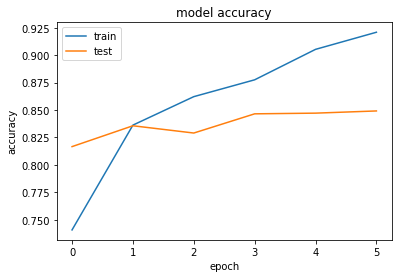

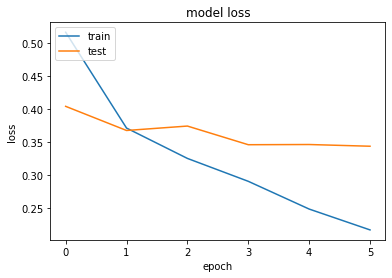

In [50]:
# Train cnn and print graphs
model = create_model_cnn(vocab_size, embedding_matrix)
print(model.summary())
model = train_cnn(X_train, y_train, X_test, y_test, model)
# Save the model 
model.save("")

In [51]:
# Particular prediction with the CNN model
model = create_model_cnn(vocab_size, embedding_matrix)
rvw = ['I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned']
make_prediction(model, checkpoint_filepath_cnn, rvw)

[0.10267548]
The review is negative


[0.         0.14069744 1.        ] [0.         0.84322286 1.        ] 0.8512627108233264


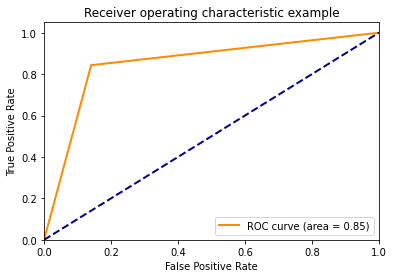

In [41]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve with the CNN model
model = create_model_cnn(vocab_size, embedding_matrix)
model.load_weights(checkpoint_filepath_cnn)
predictions = model.predict(X_test)
predictions[predictions > 0.5] = 1
predictions[predictions <= 0.5] = 0

fpr, tpr, _ = roc_curve(y_test.reshape(-1, 1), predictions.astype('int'))
roc_auc = auc(fpr, tpr)
print (fpr, tpr, roc_auc)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 100)          9254700   
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 61s 2ms/step - loss: 0.5452 - acc: 0.7152 - val_loss: 0.4796 - val_acc: 0.7808
Epoch 2/6
32000/32000 [==============================] - 54s 2ms/step - loss: 0.4462 - acc: 0.7938 - val_loss: 0.3999 - val_acc: 0.8145
Epoch 3/6
32000/32000 [==============================] - 55s 2ms

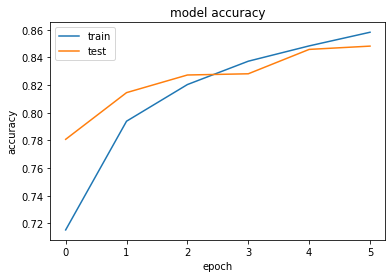

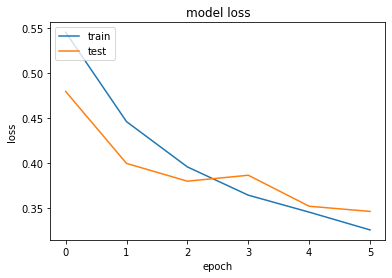

In [52]:
# Train lstm model and print graphs
model = create_model_lstm(vocab_size, embedding_matrix)
print(model.summary())
model = train_lstm(X_train, y_train, X_test, y_test, model)

In [53]:
# Particular prediction with the LSTM model
model = create_model_lstm(vocab_size, embedding_matrix)
rvw = ['I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned']
make_prediction(model, checkpoint_filepath_lstm, rvw)

[0.32091218]
The review is negative


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          84480     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 9,438,125
Trainable params: 183,425
Non-trainable params: 9,254,700
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 109s 3ms/step - loss: 0.7136 - acc: 0.6011 - val_loss: 0.6323 - val_acc: 0.6238
Epoch 2/6
32000/320

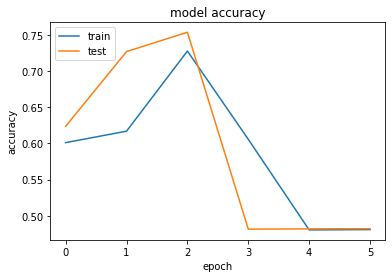

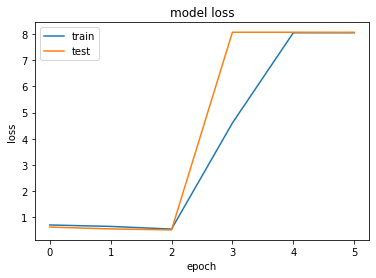

In [35]:
# Train Bilateral model
model = create_bilateral_lstm(vocab_size, embedding_matrix)
print(model.summary())
model = train_bilateral_lstm(X_train, y_train, X_test, y_test, model)

In [54]:
# Particular prediction with the Bilateral LSTM model
model = create_bilateral_lstm(vocab_size, embedding_matrix)
rvw = ['I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned']
make_prediction(model, checkpoint_filepath_bi_lstm, rvw)

[0.39173326]
The review is negative


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
gru_1 (GRU)                  (None, 100, 64)           31680     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,311,213
Tra

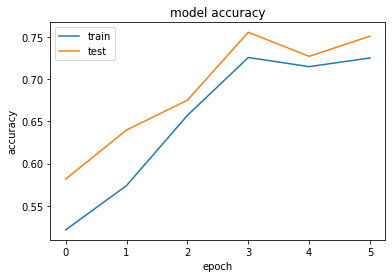

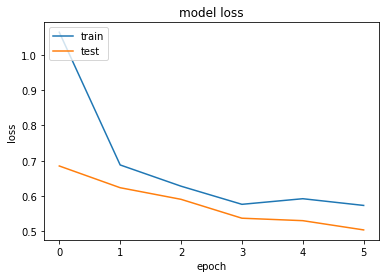

In [41]:
# Train Gru model
model = create_gru(vocab_size, embedding_matrix)
print(model.summary())
model = train_gru(X_train, y_train, X_test, y_test, model)

In [55]:
# Particular prediction with the GRU model
model = create_gru(vocab_size, embedding_matrix)
rvw = ['I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned']
make_prediction(model, checkpoint_filepath_gru, rvw)

[0.47114113]
The review is negative


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 9,284,951
Trainable params: 30,251
Non-trainable params: 9,254,700
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 27s 841us/step -

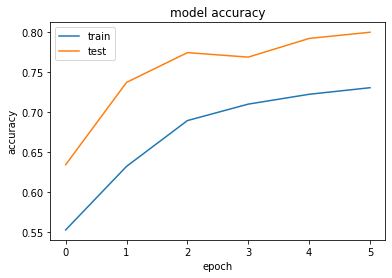

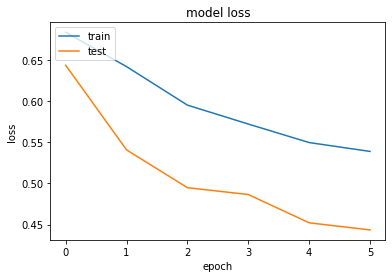

In [46]:
# Train the trying to improve the LSTM model
model = create_impr_lstm(vocab_size, embedding_matrix)
print(model.summary())
model = train_impr_lstm(X_train, y_train, X_test, y_test, model)

In [56]:
# Particular prediction with the improved model
model = create_gru(vocab_size, embedding_matrix)
rvw = ['I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned']
make_prediction(model, checkpoint_filepath_gru, rvw)

[0.47114113]
The review is negative
